In [172]:
%matplotlib inline

In [499]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
import seaborn as sns
import os
import shutil
import re
import networkx as nx

### Loading images, Checking dimensions

In [398]:
! ls 

align_faculty_pics                  face-alignment.zip
align_student_pics                  faculty_pics
crop_faculty_pics                   haarcascade_frontalface_default.xml
eigenfaces.ipynb                    resized_faculty_pics
face-alignment                      student_pics


Loading the pictures. We have 2 directories. 1 has all of USF MSAN's faculty headshots, other has student's headshots. 

In [416]:
path = '/Users/princegrover/Documents/msan/compstats/pca/'

In [417]:
student_pic_list = os.listdir(path + 'student_pics')
faculty_pic_list = os.listdir(path + 'faculty_pics')

In [418]:
len(student_pic_list), len(faculty_pic_list) # num students, num faculty

(79, 14)

In [419]:
student_pic_list[:2]

['avgerinou-danai.jpg', 'bowers-devin.jpg']

In [420]:
# shape of random student pic

plt.imread(path + 'student_pics/' + student_pic_list[1]).shape

(150, 150, 3)

In [421]:
# shape of random facult pic

plt.imread(path + 'faculty_pics/' + faculty_pic_list[1]).shape

(500, 500, 3)

Checking if dimension for all images in these 2 folders is same

In [422]:
# check if dimention of all images in student is same

i = 0
for st in range(len(student_pic_list)):
    arr = plt.imread(path + 'student_pics/' + student_pic_list[st])
    if (arr.shape[0] == 150) and (arr.shape[1] == 150):
        i += 1
assert i == len(student_pic_list)

In [424]:
# check if dimention of all images in faculty is same

# i = 0
# for st in range(len(faculty_pic_list)):
#     arr = plt.imread(path + 'faculty_pics/' + faculty_pic_list[st])
#     if (arr.shape[0] == 500) and (arr.shape[1] == 500):
#         i += 1
# assert i == len(faculty_pic_list)

In [425]:
student_pic_list[1]

'bowers-devin.jpg'

In [426]:
# funciton to plot 4 pictures in 1 row 

def plot_4_pics(dir_lst, dr):
    """
    Displays 4 random images from a directory of images
    
    dir_lst: list of image paths from where we want to show images
    dr: student_pics or faculty_pics
    
    """
    
    fig, ax = plt.subplots(ncols=4, nrows=1, figsize = (12,5))
    
    # random 4 pictures from list
    np.random.seed(10)
    idxs = np.random.randint(0, len(dir_lst), 4)
    
    for i,idx in enumerate(idxs):
        p = path + dr + dir_lst[idx]
        img_ar = plt.imread(p)
        ax[i].imshow(img_ar)
        
        fig.suptitle(dr, y = 0.85, fontsize=15)
        fig.tight_layout()

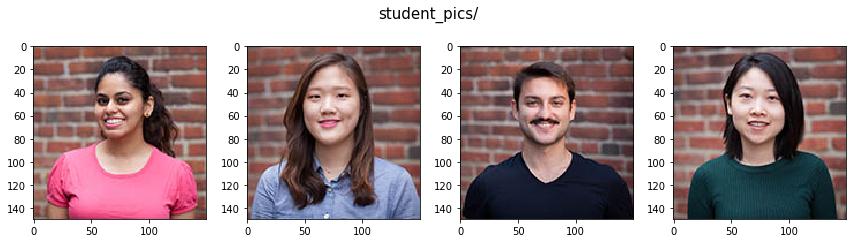

In [427]:
plot_4_pics(student_pic_list, 'student_pics/')

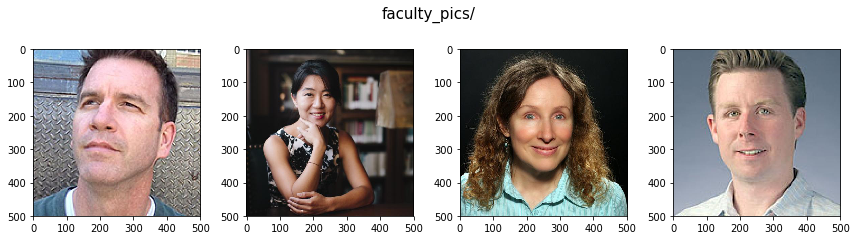

In [428]:
plot_4_pics(faculty_pic_list, 'faculty_pics/')

### Image pre-processing

#### Resizing images

Since all faculty images are 500x500 and we would like to have same dimension for all images. Resizing it. 

In [429]:
def resize(in_dir, out_dir, file_list , sz):
    """
    Resized all images from input directory to given sz and saves into output directory
    
    in_dir: path to input dir
    out_dir: path to output dir
    file_list: list of image paths to be resized
    sz: final size needed 
    
    """
    
    os.makedirs(out_dir, exist_ok=True) # create empty out_dir if not exist already
    
    for pic in file_list:
        ar  = cv2.imread(in_dir + pic)
        ar_out = cv2.resize(ar, (150,150))       
        cv2.imwrite(out_dir + pic, ar_out)

In [430]:
in_dir = path + 'faculty_pics/'
out_dir = path + 'resized_faculty_pics/'
resize(in_dir, out_dir, faculty_pic_list, 150)

In [431]:
resized_faculty_pic_list = os.listdir(path + 'resized_faculty_pics/')

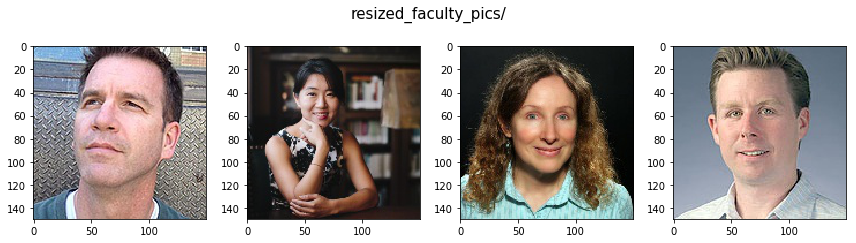

In [432]:
plot_4_pics(resized_faculty_pic_list, 'resized_faculty_pics/')

#### Cropping faces 
Code borrowed from http://gregblogs.com/computer-vision-cropping-faces-from-images-using-opencv2/

In [191]:
def facechop(in_dir, out_dir, file_lst):  
    """
    
    """
    os.makedirs(out_dir, exist_ok=True)

    facedata = "haarcascade_frontalface_default.xml"
    cascade = cv2.CascadeClassifier(facedata)
    
    for i in file_lst:
        image = in_dir + i  # actual path of the image
        img = cv2.imread(image)
        faces = cascade.detectMultiScale(img)

        for f in faces:
            x, y, w, h = [ v for v in f ]
            cv2.rectangle(img, (x,y), (x+w,y+h), (255,255,255))

            sub_face = img[y:y+h, x:x+w]
            face_file_name = out_dir + str(y) + str(i)+ ".jpg"
            cv2.imwrite(face_file_name, sub_face)

        cv2.imshow(image, img)
    return None

In [163]:
# cropping faculty faces 

in_dir = path + 'resized_faculty_pics/'
out_dir = path + 'crop_faculty_pics/'
facechop(in_dir, out_dir, resized_faculty_pic_list)

Let's see how it looks like 

In [164]:
crop_faculty_pic_list = os.listdir(path + 'crop_faculty_pics/')

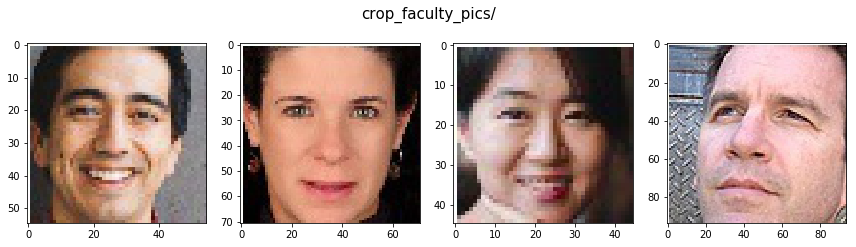

In [165]:
plot_4_pics(crop_faculty_pic_list, 'crop_faculty_pics/')

#### Aligning and cropped faces 

Eigen faces would give good results without aligning faces 
Taken from: https://www.pyimagesearch.com/2017/05/22/face-alignment-with-opencv-and-python/

In [433]:
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import imutils
import dlib

In [434]:
def align_faces(in_dir, out_dir, file_lst, width = 150):
    
    """
    Align, crops faces and saves in output directory
    
    """
    
    os.makedirs(out_dir, exist_ok=True)
    
    # initialize dlib's face detector (HOG-based) and then create
    # the facial landmark predictor and the face aligner
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(path + 'face-alignment/shape_predictor_68_face_landmarks.dat')
    fa = FaceAligner(predictor, desiredFaceWidth=width)
    
    for file in file_lst:
        
        image_path = in_dir + file  # actual path of the image
        image = cv2.imread(image_path)
#         image = imutils.resize(image, width=150)
        convert = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # to RGB

        # show the original input image and detect faces in the grayscale
        # image
        cv2.imshow("Input", image)
        rects = detector(convert, 2)

        # loop over the face detections
        for rect in rects:
                # extract the ROI of the *original* face, then align the face
                # using facial landmarks
                (x, y, w, h) = rect_to_bb(rect)
                faceOrig = imutils.resize(image[y:y + h, x:x + w], width=width)
                faceAligned = fa.align(image, convert, rect)
                
                faceGray = np.stack((cv2.cvtColor(faceAligned, cv2.COLOR_RGB2GRAY),
                                     cv2.cvtColor(faceAligned, cv2.COLOR_RGB2GRAY),
                                     cv2.cvtColor(faceAligned, cv2.COLOR_RGB2GRAY)),
                                    axis=-1)
                
                cv2.imwrite(out_dir + file, faceGray)

In [435]:
# aligning, cropping faculty faces 

in_dir = path + 'faculty_pics/'
out_dir = path + 'align_faculty_pics/'
align_faces(in_dir, out_dir, faculty_pic_list)

In [285]:
# aligning, cropping students faces 

in_dir = path + 'student_pics/'
out_dir = path + 'align_student_pics/'
align_faces(in_dir, out_dir, student_pic_list)

**Let's visualize a few images now and see what alignment did**

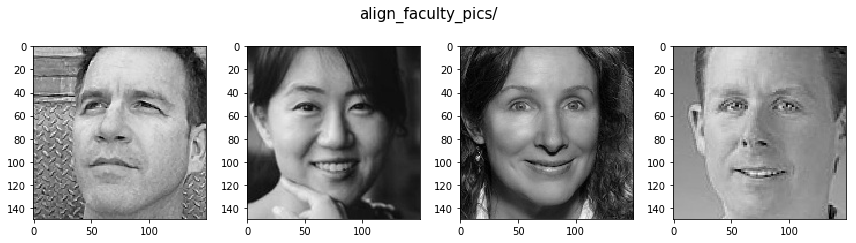

In [436]:
plot_4_pics(faculty_pic_list, 'align_faculty_pics/')

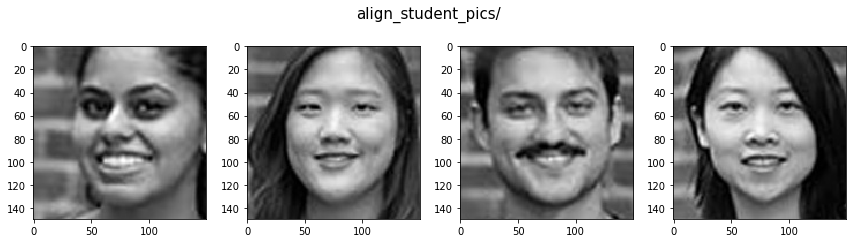

In [287]:
plot_4_pics(student_pic_list, 'align_student_pics/')

### Eigen faces

#### Step 1: Data matrix
We have collected pictures which are **aligned, face-cropped, converted to gray scale and all have same (h,w,c) dimentions. (i.e 150x150x3)**. This is very important step to get good eigen faces and also to regenrate faces at the end. Now, first step is to reshape each image into a vector of shape: (hxwxc,1). Then we create a matrix of data where each column represents an image vector. 

In [437]:
def create_data_matrix(in_dir, file_lst):
    """
    Creates a data matrix where each column correspond to image array vector of an image
    
    """
    
    sam_img_ar = plt.imread(in_dir + file_lst[0])
    dm = np.zeros((sam_img_ar.shape[0]*sam_img_ar.shape[1]*sam_img_ar.shape[2], len(file_lst)), dtype=np.float32) # initialize matrix r*g*b*c, num pics
    
    for i,f in enumerate(file_lst):
        img_ar = plt.imread(in_dir + f)
        dm[:,i] = img_ar.flatten()
    
    return dm 

In [438]:
in_dir = path + 'align_faculty_pics/'
faculty_dm  = create_data_matrix(in_dir, faculty_pic_list)

In [439]:
faculty_dm.shape

(67500, 14)

In [339]:
in_dir = path + 'align_student_pics/'
student_dm  = create_data_matrix(in_dir, student_pic_list)

In [340]:
student_dm.shape

(67500, 79)

#### Step 2: Normalizing image by subtracting from matrix mean

In order to get the average faculty and student face, we need to take the average of the column vectors for all images and reshape to visible format. 

Mean faculty face

In [440]:
mean_faculty = np.mean(faculty_dm, axis=1)
mean_faculty= mean_faculty[:,None]

In [441]:
faculty_dm_norm = faculty_dm - mean_faculty

In [442]:
faculty_dm_norm.shape

(67500, 14)

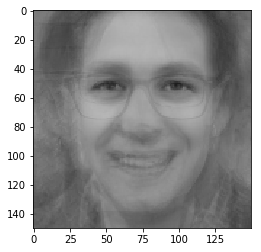

In [443]:
plt.imshow(mean_faculty.reshape((150,150,3))/255.)

Mean student face

In [330]:
mean_student = np.mean(student_dm, axis=1)
mean_student= mean_student[:,None]

In [331]:
student_dm_norm = student_dm - mean_student

In [332]:
student_dm_norm.shape

(67500, 79)

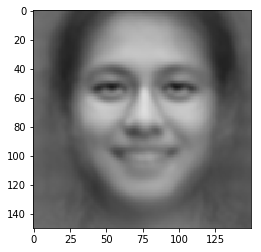

In [333]:
plt.imshow(mean_student.reshape((150,150,3))/255.)

#### Step 3: Getting eigen faces (eigen vectors) of normalized matrix. (aka Covariance matrix)  

Each eigenvector can be seen as an image itself and will have same dimension  of h,w,c. These eigen vectors are called eigen faces as each vector represents a face in itself. The matrix represents, how off each face vector is from mean face vector. The vectors represent `directions` in which each face vector vary from mean face.  

Using `sklearnPCA` API to get these eigen vectors

In [355]:
from sklearn.decomposition import PCA as sklearnPCA

** Faculty eigen faces ** 

In [444]:
pca_fac = sklearnPCA()

# on faculty
eigenFaces_fac = pca_fac.fit_transform(faculty_dm_norm)

eigenValues_fac = pca_fac.explained_variance_ratio_

In [445]:
eigenFaces_fac

array([[-8.0069221e+01,  9.2506073e+01, -5.7335068e+01, ...,
        -2.2668889e+00, -1.6420059e+01,  2.0525916e-04],
       [-8.0076134e+01,  9.2499069e+01, -5.7332954e+01, ...,
        -2.2686355e+00, -1.6419701e+01,  3.8947011e-03],
       [-8.0064903e+01,  9.2497681e+01, -5.7337135e+01, ...,
        -2.2673004e+00, -1.6419479e+01, -2.6333875e-03],
       ...,
       [-1.1402512e+02,  1.9495926e+01,  1.6062234e+02, ...,
         1.5706743e+01, -3.8780483e+01, -2.5732738e-06],
       [-1.1402512e+02,  1.9495926e+01,  1.6062234e+02, ...,
         1.5706743e+01, -3.8780483e+01, -2.5732738e-06],
       [-1.1402512e+02,  1.9495926e+01,  1.6062234e+02, ...,
         1.5706743e+01, -3.8780483e+01, -2.5732738e-06]], dtype=float32)

In [446]:
eigenFaces_fac.shape

(67500, 14)

In [447]:
eigenValues_fac

array([3.15190095e-01, 2.35980637e-01, 1.14048002e-01, 6.03006073e-02,
       5.31158092e-02, 4.10282149e-02, 3.88881034e-02, 3.21223049e-02,
       2.77364088e-02, 2.36351927e-02, 2.26478730e-02, 1.96742008e-02,
       1.56325506e-02, 2.82477749e-14])

In [361]:
def imgNorm(img):
    '''
    Normalizing image matrix to get values between 0 to 1 
    To be use for eigen vector output as it has values outside this range also 
    and would not be able to give meaningful visual
    
    img: image matrixtrix normalized between [0,1]
    
    '''
    cmin = img.min()
    cmax = img.max()
    return (img - cmin) / (cmax - cmin)

Let's see top 4 eigen faces. Top means vectors which have highest eigen values

In [379]:
def plot_4_egn_fcs(eigenvectors, title):
    """
    Plots top 4 eigen faces, based on their eigen values
    """

    fig, ax = plt.subplots(ncols=4, nrows=1, figsize = (12,5))

    # random 4 pictures from list
    np.random.seed(10)
    idxs = np.random.randint(0, eigenFaces_fac.shape[1], 4)

    for i,idx in enumerate(idxs):
        p = imgNorm(eigenvectors[:,i])
        img_ar = p.reshape((150,150,3))
        ax[i].imshow(img_ar)

        fig.suptitle("Top 4 eigen faces of " + title, y = 0.85, fontsize=15)
        fig.tight_layout()

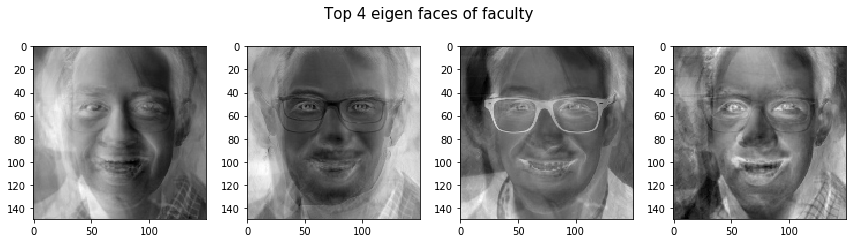

In [448]:
plot_4_egn_fcs(eigenFaces_fac, 'faculty')

** Student eigen faces **

In [382]:
pca_st = sklearnPCA()

# on faculty
eigenFaces_st = pca_st.fit_transform(student_dm_norm)

eigenValues_st = pca_st.explained_variance_ratio_

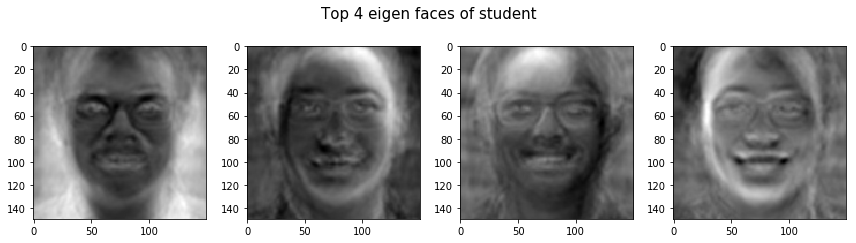

In [383]:
plot_4_egn_fcs(eigenFaces_st, 'student')

#### Step 4: Variance explained

We can plot the variance explained by eigen vectors and decide how many vectors are needed to explain > threshold variability of data or use elbow method to decide number of eigen vectors needed to reconstruct the image

** Faculty **

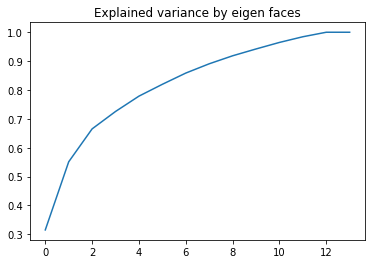

In [449]:
# variance explained faculty eigen vectors

plt.plot(np.cumsum(pca_fac.explained_variance_ratio_))
plt.title('Explained variance by eigen faces')
plt.show()

In [450]:
print("The first 4 eigen faces explains ",
      str(np.sum(pca_fac.explained_variance_ratio_[:4])),
      " of the total variability")

The first 4 eigen faces explains  0.725519341544098  of the total variability


** Students ** 

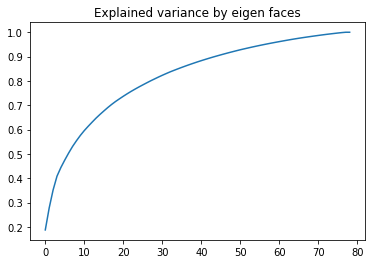

In [385]:
# variance explained students eigen vectors

plt.plot(np.cumsum(pca_st.explained_variance_ratio_))
plt.title('Explained variance by eigen faces')
plt.show()

In [386]:
print("The first 4 eigen faces explains ",
      str(np.sum(pca_st.explained_variance_ratio_[:4])),
      " of the total variability")

The first 4 eigen faces explains  0.40825279121748553  of the total variability


In [389]:
print("The first 20 eigen faces explains ",
      str(np.sum(pca_st.explained_variance_ratio_[:20])),
      " of the total variability")

The first 20 eigen faces explains  0.7261793042475393  of the total variability


So for students, we would need more number of eigen vectors to be able to explain > threshold of variance

#### Step 5: Reconstruction

The idea is simple. Since eigen vectors are just a linear combination of original image vectors. We can reconstruct the original image using linear combination of eigen vectors. Now we don't necessarily need all eigen vectors to reconstruct the image because top N eigen vectors are able to explain 70-80% of image as we observe in above `variance explained plots`

** Sample faculty **

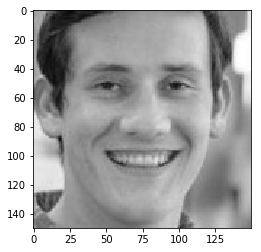

In [451]:
james_o = cv2.imread(path + 'align_faculty_pics/' + 'james-wilson.jpg')
plt.imshow(james_o)

In [454]:
def eigfacesCombination(eigenfaces, targetImg):
    """
    Solve for Ax = b with OLS
    eigenfaces: eigen faces matrix
    targetImg: Image to reconstruct
    w: weights
    """
    w = np.linalg.lstsq(eigenfaces, targetImg.flatten(), rcond=None)[0]
    return w

In [458]:
def imgReconstruct(eigenFaces, weights, numFaces):
    reconstruct = np.zeros((150, 150, 3))
    for i in range(numFaces):
        reconstruct += (eigenFaces[:, i] * weights[i]).reshape(150, 150, 3)
    return reconstruct

In [455]:
img_mean_norm = (james_o.flatten() - mean_faculty.flatten()).reshape(150, 150, 3)

In [460]:
weights_fac = eigfacesCombination(eigenFaces_fac, img_mean_norm)

In [461]:
weights_fac

array([-1.3524407e-01,  1.8817163e-01,  1.6071360e-01, -3.4532639e-01,
       -1.9396859e-01,  1.4672987e-01,  2.4128549e-01,  2.3231281e-02,
        2.4449746e-01, -5.3283930e-01, -3.0416662e-01,  1.8702351e-01,
        3.7508872e-01,  2.8575100e+05], dtype=float32)

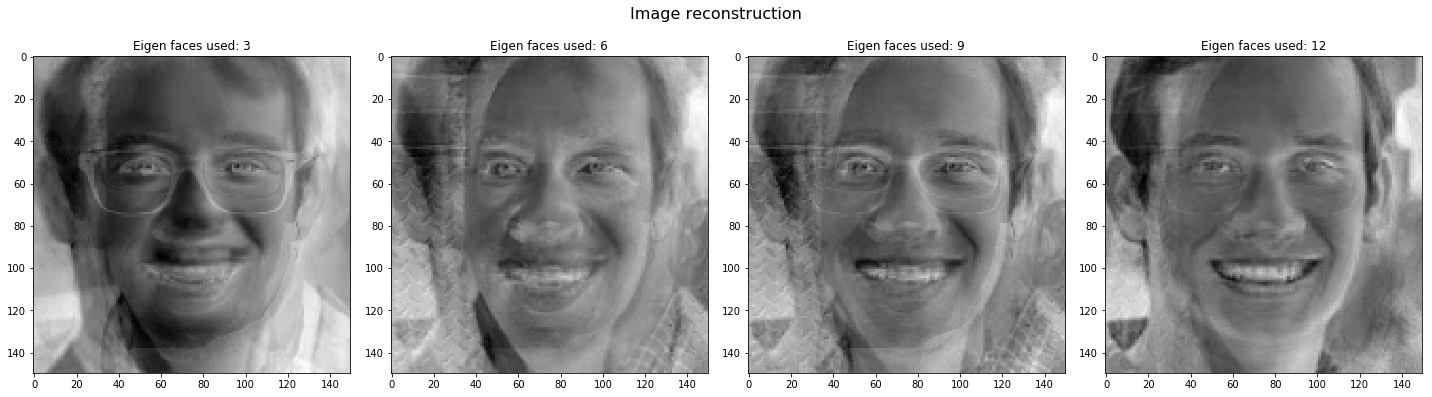

In [462]:
# reconstructing image sequentially using eigen vectors

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 6))
for i in range(4):
    axes[i].imshow(
        imgNorm(imgReconstruct(eigenFaces_fac, weights_fac, 3 * (i + 1))))
    axes[i].set_title(f"Eigen faces used: {3 * (i + 1)}")
plt.suptitle('Image reconstruction', fontsize=16)
fig.tight_layout()

Looks like James's picture comes mostly from Jeff's picture based on use of top 3 eigen faces

** Sample student's ** 

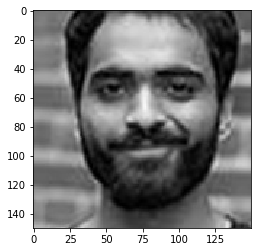

In [467]:
self_img = cv2.imread(path + 'align_student_pics/' + 'grover-prince_0.jpg')
plt.imshow(self_img)

In [468]:
img_mean_norm = (self_img.flatten() - mean_student.flatten()).reshape(150, 150, 3)

In [469]:
weights_st = eigfacesCombination(eigenFaces_st, img_mean_norm)

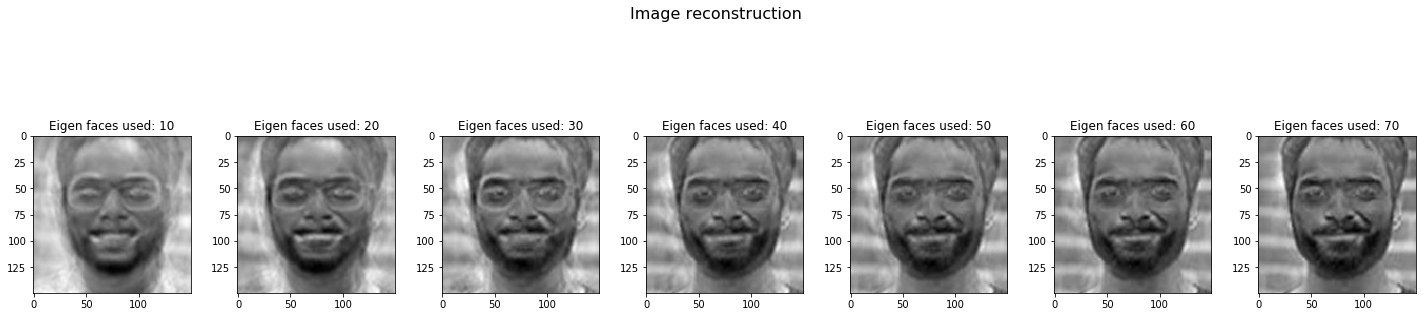

In [476]:
# reconstructing image sequentially using eigen vectors

fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(20, 6))
for i in range(7):
    axes[i].imshow(
        imgNorm(imgReconstruct(eigenFaces_st, weights_st, 10 * (i+1))))
    axes[i].set_title(f"Eigen faces used: {10 * (i + 1)}")
fig.suptitle('Image reconstruction', fontsize=16)
fig.tight_layout()

### Similarity network

We can make a adjacency matrix of pairwise cosine similarity/ correlation coefficient for all students/ faculty. And use that adjacency matrix to make a graph network

Getting eigenvector representation for all people.  

** For students ** 

In [483]:
student_pic_list[:2]

['avgerinou-danai.jpg', 'bowers-devin.jpg']

In [482]:
student_names = [i.replace('.jpg','') for i in student_pic_list]

In [492]:
# storing reconstructed image in the form of 

stud_ev_dict= {}

for file, name in zip(student_pic_list, student_names):
    img = cv2.imread(path + 'align_student_pics/' + file)
    img_mean_norm = (img.flatten() - mean_student.flatten()).reshape(150, 150, 3)
    weights = eigfacesCombination(eigenFaces_st, img_mean_norm)
    stud_ev_dict[name] = imgReconstruct(eigenFaces_st, weights, len(student_names)).flatten()
    

In [493]:
stud_ev_dict['bowers-devin'].shape

(67500,)

In [494]:
stud_ev_df = pd.DataFrame.from_dict(stud_ev_dict)

In [495]:
stud_ev_df[:5]

,avgerinou-danai,bowers-devin,campa-ryan,capell-holly,carpenter-jason,chen-liz,chen-si,csiszar-chris,dong-chris,doshi-neerja,...,white-tyler,xu-chengcheng,xu-chuan,xu-zhengjie,yan-dixin,yang-patrick,yue-lan,yun-yu,zhao-yiqiang,zheng-vanessa
0,21.873464,-15.991337,-24.580004,12.583762,-38.778633,34.433780,58.025633,-5.171933,0.744822,-27.255923,...,-50.827587,-56.109608,-35.678031,-43.167409,17.964113,28.781334,-24.995949,-10.379760,-3.627873,27.135489
1,11.259072,-13.556419,-21.648401,16.088546,-31.422048,28.944040,40.507828,-3.301893,4.200323,-25.049271,...,-48.755124,-48.026295,-28.975429,-38.182940,10.750885,24.741383,-30.351047,-16.862707,1.812075,20.804628
2,5.103966,-12.143063,-19.949321,18.119085,-27.155284,25.760058,30.348651,-2.221265,6.202812,-23.770698,...,-47.553022,-43.339444,-25.088925,-35.292825,6.568980,22.399695,-33.455328,-20.621000,4.966459,17.133185
3,-36.980730,-5.512237,-6.394215,31.897834,-8.399017,6.590598,-41.574688,2.203386,17.783790,-14.028445,...,-39.330879,-11.758596,3.121162,-15.757346,-17.302094,6.866406,-54.106850,-44.651026,28.270787,-9.310965
4,-80.791599,4.541882,5.703541,46.357204,21.968171,-16.066532,-113.891856,9.911401,32.033689,-4.920767,...,-30.771682,21.608955,30.784026,4.815798,-47.077564,-9.805507,-76.214742,-71.411263,50.723542,-35.447186


In [496]:
corr_st = stud_ev_df.corr()  #correlation matrix using representation

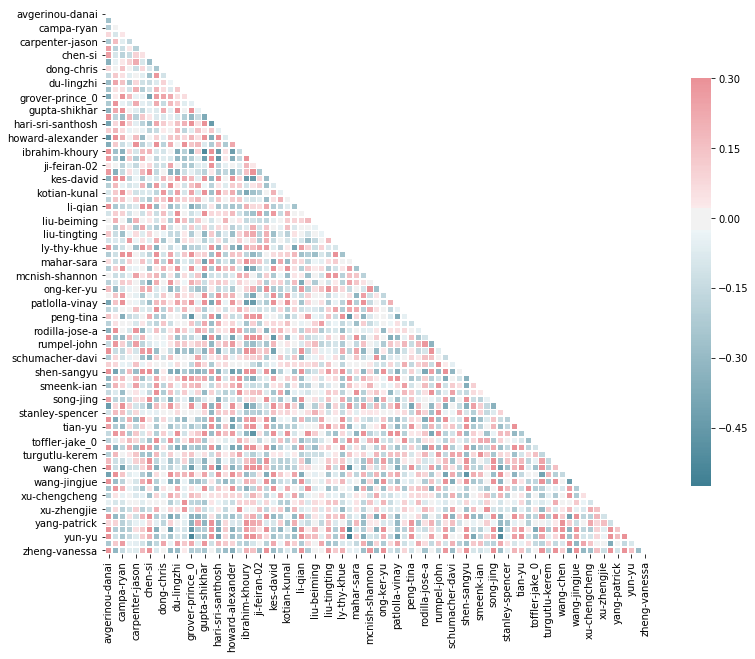

In [502]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_st, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and corr_stect aspect ratio
sns.heatmap(corr_st, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.75, cbar_kws={"shrink": .75})

In [ ]:
corr_st.rename()

In [537]:
corr_st_stack = corr_st.stack().reset_index().sort_values(0, ascending=False)

In [538]:
corr_st_stack.columns = ['st1', 'st2', 'corr']

In [539]:
corr_st_stack = corr_st_stack[corr_st_stack['corr'] != 1.0]

In [540]:
corr_st_stack = corr_st_stack.drop_duplicates(['corr'])

In [554]:
# top 10 correlated students

corr_st_stack[:10]

,st1,st2,corr
5445,wang-jingjue,yan-dixin,0.728068
5400,wang-jingjue,li-qian,0.660251
5029,tollas-kaya,shen-sangyu,0.659949
5795,yan-dixin,li-qian,0.637869
1005,grover-prince_0,sooraj,0.634326
5819,yan-dixin,shen-sangyu,0.629098
4430,song-jing,chen-si,0.613080
4977,tollas-kaya,avgerinou-danai,0.602828
2068,kotian-kunal,gupta-shikhar,0.583205
3542,peng-tina,wang-chen,0.582603


Let's try to make a graph using `corr_df` as adjacency matric

In [561]:
# creating a network of top 50 relations based on correlation coeffienct
G = nx.from_pandas_edgelist(corr_st_stack[:50], 'st1', 'st2', 'corr')

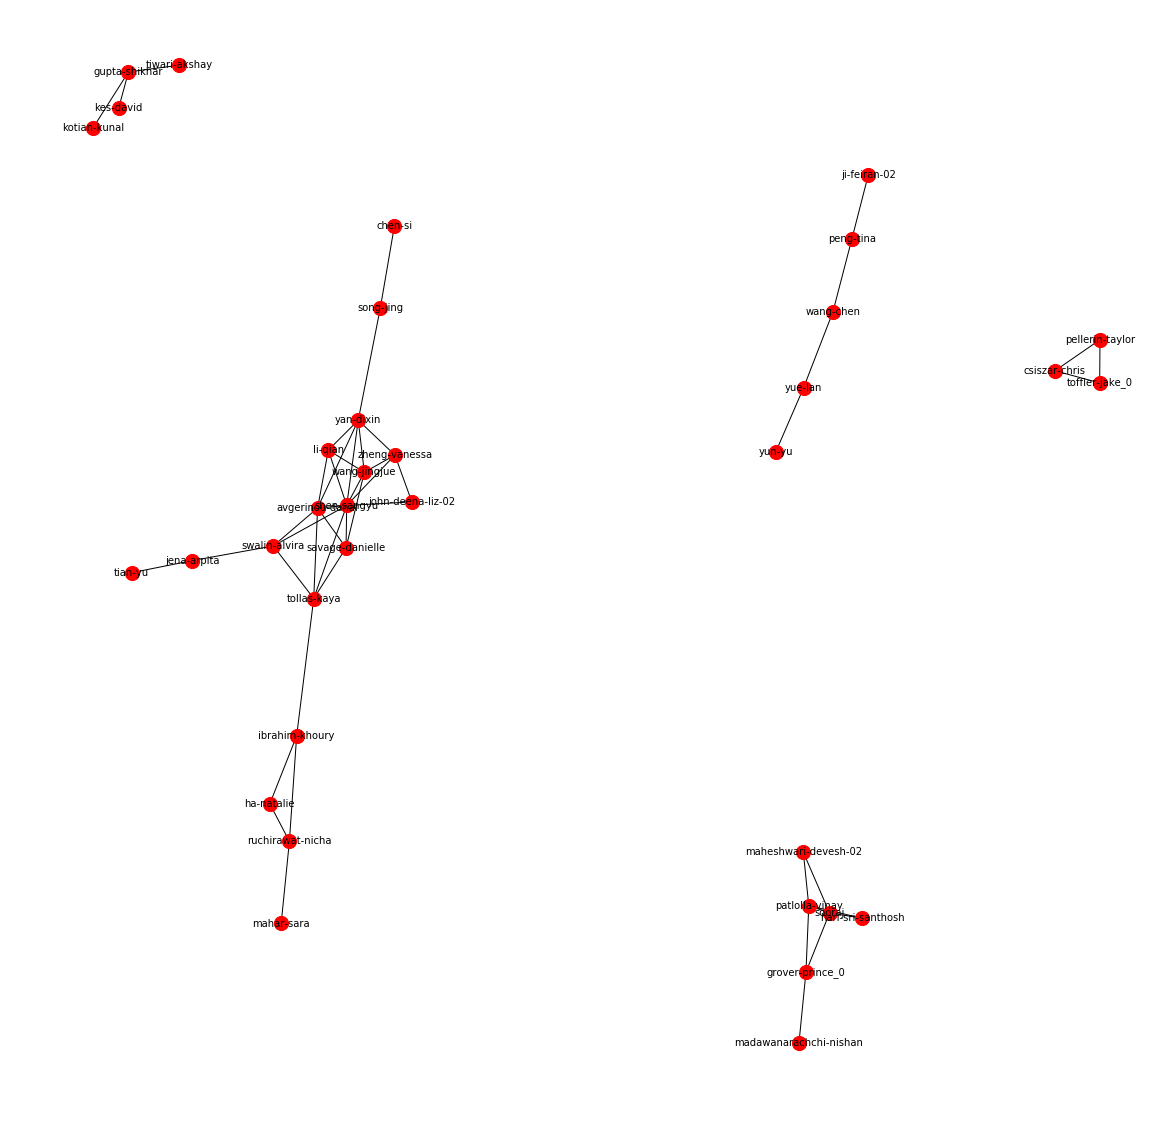

In [562]:
# visualizing the network
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
nx.draw(
    G,
    with_labels=True,
    node_color='red',
    node_size=200,
    edge_color='black',
    linewidths=1,
    font_size=10,
    ax=axes,
    pos=nx.fruchterman_reingold_layout(G))

** Graph for faculty ** 

In [563]:
faculty_pic_list[:2]

['2147483669_u_devlin_s.jpg', '6442451308_u_mikeb_photo.jpg']

In [564]:
faculty_names = [i.replace('.jpg','') for i in faculty_pic_list]

In [565]:
# storing reconstructed image in the form of 

fac_ev_dict= {}

for file, name in zip(faculty_pic_list, faculty_names):
    img = cv2.imread(path + 'align_faculty_pics/' + file)
    img_mean_norm = (img.flatten() - mean_faculty.flatten()).reshape(150, 150, 3)
    weights = eigfacesCombination(eigenFaces_fac, img_mean_norm)
    fac_ev_dict[name] = imgReconstruct(eigenFaces_fac, weights, len(faculty_names)).flatten()

In [567]:
fac_ev_df = pd.DataFrame.from_dict(fac_ev_dict)

In [568]:
fac_ev_df[:5]

,2147483669_u_devlin_s,6442451308_u_mikeb_photo,brizan-david-guy,engle_sophie,francis-lyon_patricia,hamrick-jeff1,interian-yannet,intrevado-paul,james-wilson,parr_terrence,stevens-nathaniel,thomas-rachel,uminsky_david_0,woodbridge-diane-03
0,32.402406,114.842299,-153.836973,-87.929117,-79.236165,82.845550,-161.316567,74.567739,62.056042,95.464745,148.131127,-4.065464,1.105903,-125.031435
1,1162.303981,1678.048612,-1901.171177,-1419.050317,-1355.749342,259.802374,-1891.715212,1596.643652,1116.315399,1291.868516,1623.952695,-855.983290,-200.455541,-1104.808375
2,-836.941449,-1087.885476,1190.555325,936.233981,902.915635,-53.309633,1170.058266,-1096.518090,-749.093408,-825.045261,-987.364544,651.401282,156.185434,628.806700
3,504.546825,773.609649,-893.352015,-658.024747,-572.314157,155.353776,-902.691202,710.999483,510.320156,607.637688,766.071805,-370.194375,-89.920639,-542.041421
4,599.276850,904.667550,-1039.846852,-769.625610,-679.339420,170.191866,-1047.768290,838.610887,598.708800,707.943395,889.805995,-441.619493,-106.815903,-624.188769


In [569]:
corr_fac = fac_ev_df.corr()  #correlation matrix using representation

In [570]:
corr_fac_stack = corr_fac.stack().reset_index().sort_values(0, ascending=False)

In [571]:
corr_fac_stack.columns = ['fac1', 'fac2', 'corr']

In [572]:
corr_fac_stack = corr_fac_stack[corr_fac_stack['corr'] != 1.0]

In [573]:
corr_fac_stack = corr_fac_stack.drop_duplicates(['corr'])

In [574]:
# top 10 correlated students

corr_fac_stack[:10]

,fac1,fac2,corr
171,uminsky_david_0,engle_sophie,0.529660
62,francis-lyon_patricia,interian-yannet,0.500739
117,james-wilson,hamrick-jeff1,0.444137
41,brizan-david-guy,woodbridge-diane-03,0.434538
53,engle_sophie,thomas-rachel,0.427669
95,interian-yannet,thomas-rachel,0.426331
166,thomas-rachel,uminsky_david_0,0.403691
99,intrevado-paul,6442451308_u_mikeb_photo,0.390064
1,2147483669_u_devlin_s,6442451308_u_mikeb_photo,0.371905
13,2147483669_u_devlin_s,woodbridge-diane-03,0.353907


Let's try to make a graph using `corr_df` as adjacency matric

In [577]:
# creating a network of top 20 relations based on correlation coeffienct
G = nx.from_pandas_edgelist(corr_fac_stack[:20], 'fac1', 'fac2', 'corr')

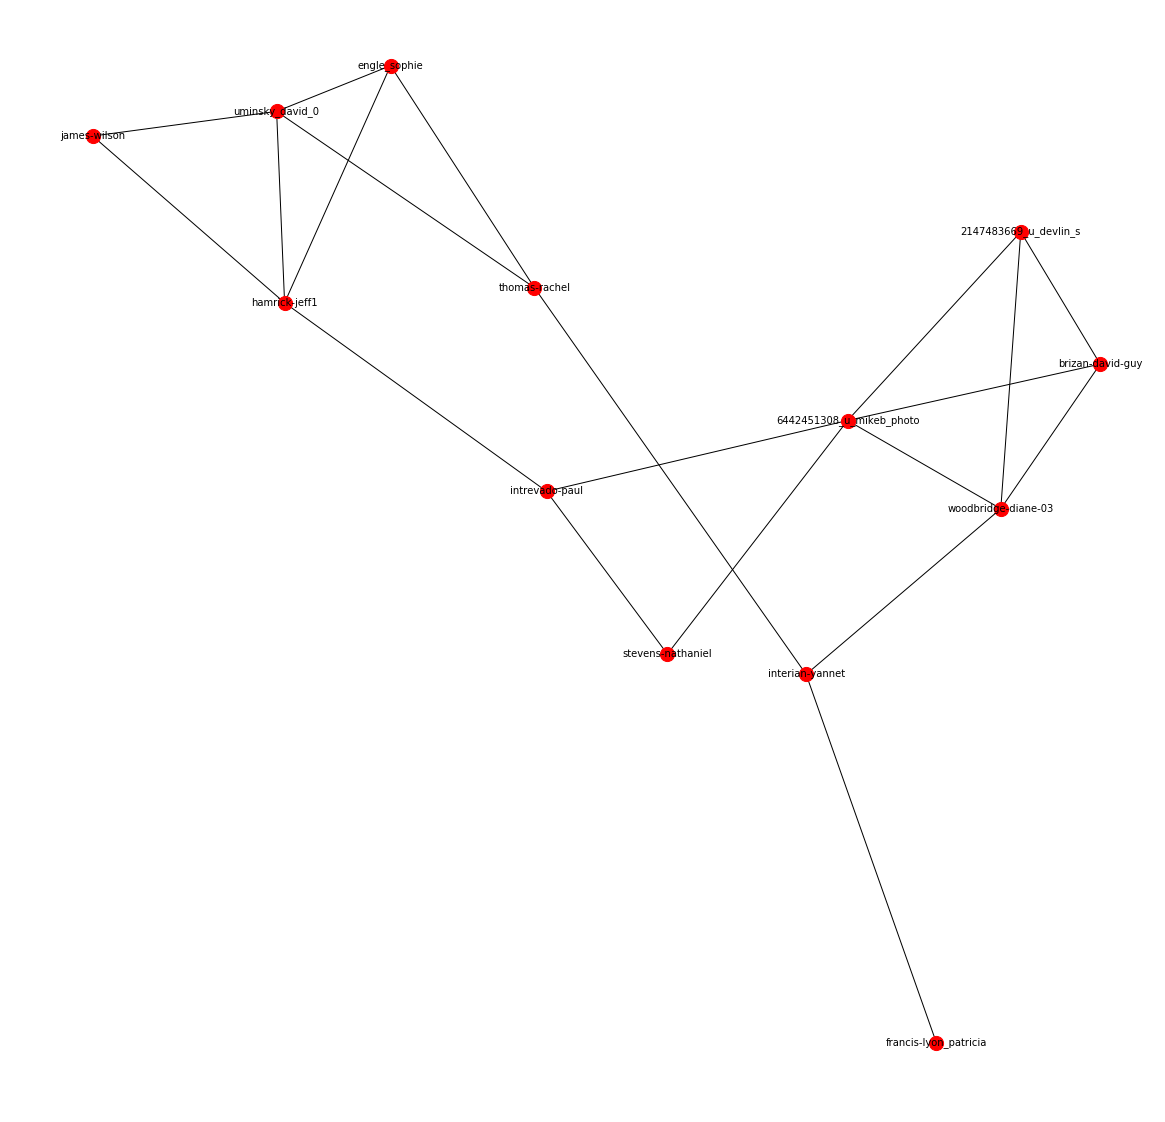

In [578]:
# visualizing the network
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
nx.draw(
    G,
    with_labels=True,
    node_color='red',
    node_size=200,
    edge_color='black',
    linewidths=1,
    font_size=10,
    ax=axes,
    pos=nx.fruchterman_reingold_layout(G))

According to graph also. James is close to Jeff. Let's see heashots'

In [582]:
corr_fac_stack[corr_fac_stack['fac1'] == 'james-wilson']

,fac1,fac2,corr
117,james-wilson,hamrick-jeff1,0.444137
124,james-wilson,uminsky_david_0,0.279853
113,james-wilson,6442451308_u_mikeb_photo,0.003987
122,james-wilson,stevens-nathaniel,-0.041592
121,james-wilson,parr_terrence,-0.177372
125,james-wilson,woodbridge-diane-03,-0.284882
118,james-wilson,interian-yannet,-0.442196
114,james-wilson,brizan-david-guy,-0.499394


In [584]:
james = cv2.imread(path + 'align_faculty_pics/' + 'james-wilson.jpg') 
jeff = cv2.imread(path + 'align_faculty_pics/' + 'hamrick-jeff1.jpg') 

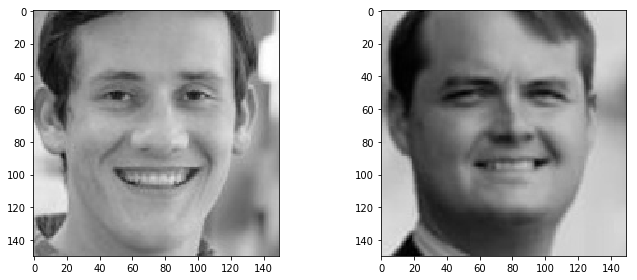

In [587]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].imshow(james)
ax[1].imshow(jeff)

fig.tight_layout()

**So, Jeff is future of James, both in terms of profession and looks. ;) **